The task of leraning semantic audio embeddings feel daunting - maybe we can help our model by pretraining the encoder to learn to distinguish words from audio?

This is providing a crutch to our model - it no longer will be unsupervised in the sense that we will levarge word labels for the pretraining. It might nonetheless be very useful to do as we work towards a fully working end to end unsupervised model.

In [1]:
from fastai.vision.all import *
from fastai.learner import *
from fastai.data.all import *
from fastai.callback.tracker import SaveModelCallback
import pandas as pd
import matplotlib.pyplot as plt
from pathlib2 import Path
import numpy as np
import random
from torch.nn import MSELoss

In [2]:
%%time

df = pd.read_csv('data/examples_with_length_speech2vec_vocab.csv')
df.shape

CPU times: user 32.1 s, sys: 3 s, total: 35.1 s
Wall time: 35.1 s


(17937758, 12)

In [3]:
df = df[((df.source_length < 70) & (df.target_length < 70) & (df.source_length > 25) & (df.target_length > 25))]
df.reset_index(drop=True, inplace=True)

In [4]:
%%time
fn2features = pd.read_pickle('data/fn2feature.pkl')

CPU times: user 17.5 s, sys: 10.1 s, total: 27.6 s
Wall time: 27.6 s


In [5]:
dataset_mean = -3
dataset_std = 12

def normalize_data(ary):
    return (ary - dataset_mean) / dataset_std

In [6]:
def empty_list(): return list()

In [7]:
%%time

word2row_idxs = defaultdict(empty_list)

for idx, row in df.iterrows():
    word2row_idxs[row.source_word].append(idx)
    
pd.to_pickle(word2row_idxs, 'data/word2row_idxs_vocab_subset.pkl')

CPU times: user 4min 50s, sys: 424 ms, total: 4min 50s
Wall time: 4min 50s


In [8]:
word2row_idxs = pd.read_pickle('data/word2row_idxs_vocab_subset.pkl')

In [9]:
def prepare_features(fn, pad_to=69, pad_left=False):
    ary = fn2features[fn][:pad_to]
    example = np.zeros((pad_to, 13))
    if pad_left:
        example[-ary.shape[0]:, :] = ary
    else: example[:ary.shape[0], :] = ary
    return example.astype(np.float32)

In [10]:
class Dataset():
    def __init__(self, df):
        self.df = df
    def __len__(self):
        return self.df.shape[0]
    def __getitem__(self, idx):
        target_fn = df.target_fn[idx]
        x = normalize_data(prepare_features(target_fn))
        return x, x

In [11]:
train_examples = df[df.set_name.isin(['train-clean-360', 'train-clean-100', 'dev-clean'])]
valid_examples = df[df.set_name == 'test-clean']

In [12]:
train_ds = Dataset(train_examples)
valid_ds = Dataset(valid_examples)

In [13]:
len(train_ds), len(valid_ds)

(3300062, 36832)

In [14]:
BS = 2048
LR = 1e-3
NUM_WORKERS = 8

train_dl = DataLoader(train_ds, BS, NUM_WORKERS, shuffle=True)
valid_dl = DataLoader(valid_ds, BS, NUM_WORKERS)

dls = DataLoaders(train_dl, valid_dl)

In [15]:
# bidirectional encoder, 1 layer, concatenate hidden state
class Model(Module):
    def __init__(self, hidden_size=25, num_layers_encoder=1):
        self.return_embeddings = False
        self.num_layers_encoder = num_layers_encoder
        self.hidden_size = hidden_size
        
        self.encoder= nn.LSTM(
            input_size=13,
            hidden_size=hidden_size,
            num_layers=self.num_layers_encoder,
            batch_first=True,
            dropout=0,
            bidirectional=True
        )
        self.decoder = nn.LSTM(
            input_size=13,
            hidden_size=2*hidden_size,
            num_layers=1,
            batch_first=True,
            dropout=0,
            bidirectional=False
        )
        self.lin = nn.Linear(2*hidden_size, 13)
            
    def forward(self, x):
        _, (embeddings, _) = self.encoder(x)
        embeddings = torch.cat((embeddings[-1], embeddings[-2]), 1)
        if self.return_embeddings: return embeddings
        
        hidden = embeddings.unsqueeze(0)
        cell = torch.zeros_like(hidden)
        input = torch.zeros_like(x[:, :1, :])
        outputs = torch.zeros_like(x)
        for t in range(x.shape[1]):
            x, (hidden, cell) = self.decoder(input, (hidden, cell))
            input = self.lin(x)
            outputs[:, t, :] = input.squeeze(1)
        return outputs

In [16]:
learn = Learner(dls.cuda(), Model().cuda(), loss_func=MSELoss(), lr=1e-3, opt_func=Adam)

In [17]:
learn.fit(20, lr=1e-3)

epoch,train_loss,valid_loss,time
0,0.761747,0.772663,02:41
1,0.700317,0.703666,02:42
2,0.644767,0.645936,02:43
3,0.587667,0.584344,02:45
4,0.546325,0.541486,02:46
5,0.514518,0.509440,02:46
6,0.491931,0.484845,02:47
7,0.461289,0.458652,02:47
8,0.446673,0.444457,02:46
9,0.430460,0.425381,02:47


In [18]:
for batch in train_dl:
    break

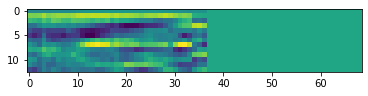

In [19]:
idx = 0
plt.imshow(batch[0][idx].cpu().numpy().T)

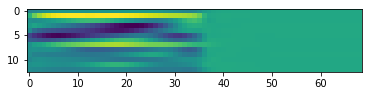

In [20]:
plt.imshow(learn.model(batch[0])[idx].detach().cpu().numpy().T)

In [21]:
learn.save('encoder_weights_unsupervised')

Path('models/encoder_weights_unsupervised.pth')